# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
- open reanalysis data
- opens ERSST observational dataset with sst sea surface temperature
- calculates the Nino3.4 index for the data to test the ENSO state in the months before and after Krakatoa 1883

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import scipy # to calculate correlation

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [5]:
# define path where netcdsf of temperature are stored
path = '/g/data/w48/kb6999/Reanalysis/20CR_TMP_data_for_plots/'

In [6]:
# open multi member mean of temperature 
mmm_mon_Glob_r = xr.open_dataset(f'{path}mmm_anom_glob.nc')

In [9]:
# reverse the latitude axis so it goes from -90 to 90
mmm_mon_Glob = mmm_mon_Glob_r.reindex(lat=list(reversed(mmm_mon_Glob_r.lat)))

In [10]:
# select out dates around kraktoa eruption 
K_mmm_mon_Glob = mmm_mon_Glob.sel(time = slice('1880','1990'))

In [12]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/Reanalysis/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [13]:
# Select out SH and NH anomalies 
K_mmm_mon_SH = K_mmm_mon_Glob.sel(lat=slice(0,-90)) 
K_mmm_mon_NH = K_mmm_mon_Glob.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
K_mmm_mon_Aus = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
K_mmm_mon_EA = K_mmm_mon_Glob.sel(lat=slice(-50,-5), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

### ERSST data (to compare with)

In [14]:
# read in obs data from ersst dataset 
ersst_path = '/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc'
ersst = xr.open_dataset(ersst_path)
if 'time_bnds' in ersst:
    del ersst['time_bnds']
ersst

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240, time: 1989)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-09-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/39)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    history:                   Thu Dec 03 18:13:58 2020: cdo remapcon,r240x12...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    Conventions:               CF-1.6, ACDD-1.3
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    ...                        ...
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2019-10-03
    CDO:                       Climate Data Operators version 1.9.8 (https://...

In [15]:
# convert to month end frequency (rahter than month start)
ersst = ersst.resample(time = 'M').mean()

In [16]:
# area weighting obs
ersst_w = ersst*np.cos(ersst.lat*(np.pi/180))

## NINO3.4

In [17]:
# calculate the nino3.4 index for multi-member mean for every month divided by std
nino34_mmm = func.nino34(mmm_mon_Glob.tmp, '1850-01', '1880-01', 1)

In [43]:
# save data as netcdf
path_R = '/g/data/w48/kb6999/Reanalysis/'
nino34_mmm.to_netcdf(f'{path_R}NINO3.4_20CR.nc')

In [18]:
# calculate the nino3.4 index for obs data for every month
nino34_obs = func.nino34(ersst_w, '1850-01', '1880-01', 0)

### Threshold 

In [19]:
# set the threshold for el nino/la nia events
THOLD = 0.4

## Figures

In [20]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [21]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [22]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [25]:
fplot=reload(fplot)

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

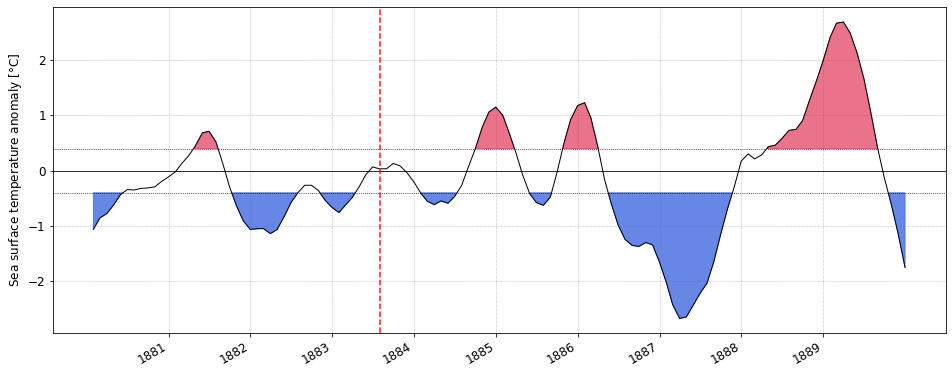

In [26]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

fplot.nino34_plot(nino34_mmm.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

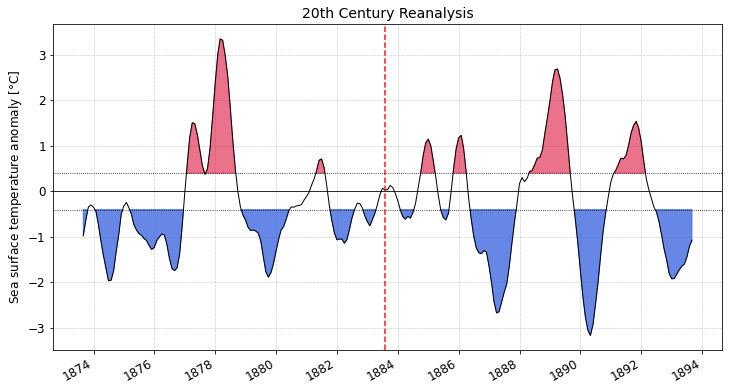

In [30]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(12,6))

# select the dataset and years to plot
start_date, end_date = '1873-08','1893-08'
ds = nino34_mmm.sel(time=slice(start_date, end_date))

fplot.nino34_plot(ds, e_date, THOLD, ax = axes)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date)+1*pd.offsets.YearBegin(), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

# set axis titles
axes.set(title = '20th Century Reanalysis')

plt.savefig('R_nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

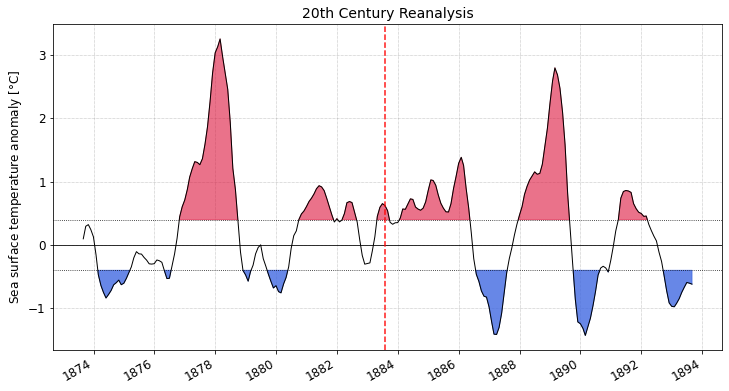

In [31]:
# plot time series of nino3.4 index for the obs ERSST dataset 
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(12,6))

# select the dataset and years to plot
start_date, end_date = '1873-08','1893-08'
ds = nino34_obs.sst.sel(time=slice(start_date, end_date))

fplot.nino34_plot(ds, e_date, THOLD, ax = axes)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date)+1*pd.offsets.YearBegin(), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

# set axis titles
axes.set(title = '20th Century Reanalysis')

plt.savefig('R_nino34_plot_obs.png', dpi=300, bbox_inches='tight')

In [72]:
fplot=reload(fplot)

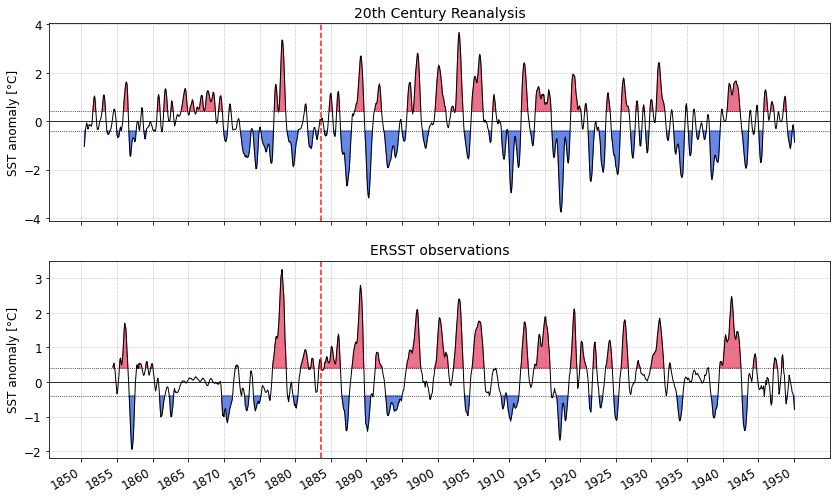

In [33]:
# plot time series of nino3.4 index for the obs ERSST dataset 
# plot time series of nino3.4 index for the multimember mean dataset 
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,8))

# select the dataset and years to plot
start_date, end_date = '1850-01','1950-01'
ds = nino34_mmm.sel(time=slice(start_date, end_date))
ds2 = nino34_obs.sst.sel(time=slice(start_date, end_date))

fplot.nino34_plot(ds, e_date, THOLD, ax = axes[0])
fplot.nino34_plot(ds2, e_date, THOLD, ax = axes[1])

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date)+1*pd.offsets.YearBegin(), freq='5YS')
axes[0].set_xticks(years.values)
axes[0].set_xticklabels(years.year) # .year shows only the year (not month)

# set axis titles
axes[0].set(title = '20th Century Reanalysis', ylabel = f'SST anomaly [{deg}C]')
axes[1].set(title = 'ERSST observations', ylabel = f'SST anomaly [{deg}C]')

plt.savefig('R_nino34_plot_ERSST+20CR.png', dpi=300, bbox_inches='tight')

## correlation

In [37]:
func=reload(func)

In [40]:
# compare ersst and 20cr
start_date, end_date = '1855-01','2015-01'

# choose 20CR data and errst data
ds = nino34_mmm.sel(time=slice(start_date, end_date))
ds2 = nino34_obs.sst.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods for the largest crossover time period
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r

# time difference correlation
func.time_diff_corr(ds, ds2)

(0.7941268507625919, 0.0)
(0.5432336130719255, 7.543740489037653e-148)


In [41]:
# compare ersst and 20cr
start_date, end_date = '1855-01','1900'

# choose 20CR data and errst data
ds = nino34_mmm.sel(time=slice(start_date, end_date))
ds2 = nino34_obs.sst.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r

# time difference correlation
func.time_diff_corr(ds, ds2)

(0.7270920955077566, 6.846463983274526e-92)
(0.5763403650061542, 4.373419994435658e-50)


In [42]:
# compare ersst and 20cr for Krakatoa dates 
start_date, end_date = '1873-08','1893-08'

# choose 20CR data and errst data
ds = nino34_mmm.sel(time=slice(start_date, end_date))
ds2 = nino34_obs.sst.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r

# time difference correlation
func.time_diff_corr(ds, ds2)

(0.9024440310519571, 2.2390420789319477e-89)
(0.6858538308872995, 1.0597420463383803e-34)
